In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     |████████████████████████████████| 512 kB 6.5 MB/s 









In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from sklearn.utils import shuffle                    
import cv2                                               
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
from torch.utils.data import DataLoader

import torch.optim as optim

2. Згорткові нейронні мережі
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [2]:
CLASS_NAMES = {
    "no_tumor": 0,
    "glioma_tumor": 1,
    "meningioma_tumor": 2,
    "pituitary_tumor": 3
}
IMAGE_SIZE = 255

In [ ]:
!unzip archive.zip

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class ImageDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.images = []
        self.labels = []
        self.transforms = transforms

        for class_name in CLASS_NAMES.keys():
            class_name_dir = os.path.join(root_dir, class_name)

            for image_file_name in os.listdir(class_name_dir):
                image_path = os.path.join(class_name_dir, image_file_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) 
        
                label = np.zeros(4)
                label[CLASS_NAMES[class_name]] = 1

                self.images.append(image/255.)
                self.labels.append(label)

        self.images = torch.FloatTensor(np.array(self.images)).view([-1, 1, IMAGE_SIZE, IMAGE_SIZE])
        self.labels = torch.FloatTensor(np.array(self.labels)).view([-1, 4])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transforms is not None:
            image = self.transforms(image)

        image = TF.adjust_contrast(image, 3)

        return image, label

train_transforms = T.Compose(
    [
        T.RandomHorizontalFlip(p=0.5), 
        T.RandomRotation(degrees=15), 
        T.RandomAffine(degrees = 0, translate = (0.15, 0.15)),
        # T.RandomInvert()
    ]
)

train_data = ImageDataset("/content/Training", transforms=train_transforms)
test_data = ImageDataset("/content/Testing")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

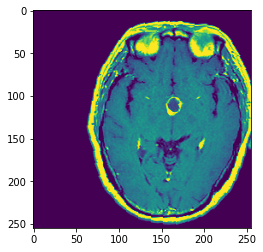

tensor([0., 0., 0., 1.])


In [5]:
img, l = next(iter(train_loader))

plt.imshow(img[0].view([255, 255]))
plt.show()
print(l[0])

In [49]:
class CnnM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(128 * 29 * 29, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [51]:
model = CnnM().to(device)

learning_rate = 0.0001
num_epochs = 200

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy = Accuracy(task="multiclass", num_classes=4)

losses = []

for epoch in range(num_epochs):
    last_running_loss = None
    running_loss = 0

    for images, labels in tqdm(train_loader):
        output = model(images.to(device))

        loss = criterion(output, labels.to(device))
        running_loss += loss
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()
    
    if last_running_loss is None:
        last_running_loss = running_loss
    
    if running_loss <= last_running_loss:
        torch.save(
            {
                'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 
            "/content/CnnM_checkpoint.pt"
        )

    print(f"Epoch {epoch + 1}; Loss {running_loss.item()}")

100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 1; Loss 118.56822204589844


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


Epoch 2; Loss 107.4170150756836


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 3; Loss 102.07604217529297


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 4; Loss 95.30435943603516


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 5; Loss 90.70255279541016


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 6; Loss 85.21930694580078


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 7; Loss 82.70819854736328


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 8; Loss 77.65921783447266


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 9; Loss 77.19227600097656


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 10; Loss 73.4363021850586


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 11; Loss 69.78494262695312


100%|██████████| 90/90 [00:19<00:00,  4.73it/s]


Epoch 12; Loss 69.0223159790039


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 13; Loss 66.15105438232422


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 14; Loss 64.29103088378906


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 15; Loss 61.74143600463867


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 16; Loss 60.8369140625


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 17; Loss 58.421722412109375


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 18; Loss 56.67634201049805


100%|██████████| 90/90 [00:18<00:00,  4.76it/s]


Epoch 19; Loss 55.83861541748047


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 20; Loss 54.3951530456543


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 21; Loss 53.12508773803711


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 22; Loss 53.17559814453125


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 23; Loss 51.597896575927734


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 24; Loss 49.22855758666992


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 25; Loss 49.34624481201172


100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch 26; Loss 48.147342681884766


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 27; Loss 47.08724594116211


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 28; Loss 45.80950164794922


100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


Epoch 29; Loss 44.19453048706055


100%|██████████| 90/90 [00:17<00:00,  5.24it/s]


Epoch 30; Loss 43.54490661621094


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 31; Loss 44.065528869628906


100%|██████████| 90/90 [00:18<00:00,  4.87it/s]


Epoch 32; Loss 43.21675491333008


100%|██████████| 90/90 [00:17<00:00,  5.22it/s]


Epoch 33; Loss 44.36530685424805


100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


Epoch 34; Loss 43.25101852416992


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 35; Loss 40.0981330871582


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 36; Loss 41.03009796142578


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 37; Loss 39.5386962890625


100%|██████████| 90/90 [00:18<00:00,  4.89it/s]


Epoch 38; Loss 40.0401725769043


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 39; Loss 39.763519287109375


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 40; Loss 38.47855758666992


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 41; Loss 37.54824447631836


100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


Epoch 42; Loss 37.536991119384766


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 43; Loss 36.94099044799805


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 44; Loss 36.1074333190918


100%|██████████| 90/90 [00:19<00:00,  4.69it/s]


Epoch 45; Loss 36.76000213623047


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 46; Loss 34.144718170166016


100%|██████████| 90/90 [00:17<00:00,  5.22it/s]


Epoch 47; Loss 35.71007537841797


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 48; Loss 34.33732604980469


100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


Epoch 49; Loss 34.81178665161133


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 50; Loss 35.057708740234375


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 51; Loss 33.1248664855957


100%|██████████| 90/90 [00:18<00:00,  4.79it/s]


Epoch 52; Loss 32.75874328613281


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 53; Loss 32.51777267456055


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 54; Loss 34.144676208496094


100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


Epoch 55; Loss 32.63548278808594


100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


Epoch 56; Loss 32.41314697265625


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 57; Loss 31.93250274658203


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 58; Loss 32.512939453125


100%|██████████| 90/90 [00:18<00:00,  4.95it/s]


Epoch 59; Loss 31.366527557373047


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 60; Loss 31.32107925415039


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 61; Loss 31.33653450012207


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 62; Loss 29.82528305053711


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 63; Loss 29.98347282409668


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 64; Loss 28.033466339111328


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 65; Loss 30.228816986083984


100%|██████████| 90/90 [00:19<00:00,  4.71it/s]


Epoch 66; Loss 29.165889739990234


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 67; Loss 27.981613159179688


100%|██████████| 90/90 [00:17<00:00,  5.22it/s]


Epoch 68; Loss 28.596406936645508


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 69; Loss 26.96573829650879


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 70; Loss 27.498748779296875


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 71; Loss 28.002904891967773


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 72; Loss 28.891054153442383


100%|██████████| 90/90 [00:18<00:00,  4.76it/s]


Epoch 73; Loss 26.825462341308594


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 74; Loss 26.735342025756836


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 75; Loss 27.30034065246582


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 76; Loss 25.041311264038086


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 77; Loss 28.629491806030273


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 78; Loss 26.3179988861084


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 79; Loss 25.505325317382812


100%|██████████| 90/90 [00:18<00:00,  4.76it/s]


Epoch 80; Loss 25.71611785888672


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 81; Loss 25.83005142211914


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 82; Loss 25.156797409057617


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 83; Loss 25.537883758544922


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 84; Loss 25.401248931884766


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 85; Loss 24.969690322875977


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 86; Loss 24.86510467529297


100%|██████████| 90/90 [00:19<00:00,  4.73it/s]


Epoch 87; Loss 24.390560150146484


100%|██████████| 90/90 [00:18<00:00,  4.93it/s]


Epoch 88; Loss 24.112579345703125


100%|██████████| 90/90 [00:18<00:00,  4.98it/s]


Epoch 89; Loss 25.62682342529297


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 90; Loss 23.60634422302246


100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch 91; Loss 22.420005798339844


100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch 92; Loss 23.852764129638672


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 93; Loss 24.422542572021484


100%|██████████| 90/90 [00:18<00:00,  4.77it/s]


Epoch 94; Loss 22.32103729248047


100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch 95; Loss 23.5072078704834


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 96; Loss 22.57289695739746


100%|██████████| 90/90 [00:17<00:00,  5.17it/s]


Epoch 97; Loss 23.096715927124023


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 98; Loss 22.156208038330078


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 99; Loss 22.65418815612793


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 100; Loss 22.256000518798828


100%|██████████| 90/90 [00:18<00:00,  4.75it/s]


Epoch 101; Loss 21.13564109802246


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 102; Loss 22.60671615600586


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 103; Loss 20.8620662689209


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 104; Loss 21.153661727905273


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


Epoch 105; Loss 21.895824432373047


100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


Epoch 106; Loss 22.441181182861328


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 107; Loss 20.171789169311523


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 108; Loss 21.014148712158203


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 109; Loss 19.88116455078125


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 110; Loss 20.509334564208984


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 111; Loss 21.605680465698242


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 112; Loss 20.862449645996094


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 113; Loss 21.186906814575195


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 114; Loss 19.94864273071289


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 115; Loss 19.676109313964844


100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


Epoch 116; Loss 19.92258071899414


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 117; Loss 19.568317413330078


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


Epoch 118; Loss 19.23560905456543


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 119; Loss 20.03929901123047


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 120; Loss 19.049203872680664


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 121; Loss 19.85152244567871


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 122; Loss 19.458328247070312


100%|██████████| 90/90 [00:18<00:00,  4.75it/s]


Epoch 123; Loss 19.02355194091797


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 124; Loss 19.65272331237793


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 125; Loss 18.330703735351562


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 126; Loss 18.77825164794922


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 127; Loss 17.759784698486328


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 128; Loss 18.31753921508789


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 129; Loss 18.521207809448242


100%|██████████| 90/90 [00:18<00:00,  4.79it/s]


Epoch 130; Loss 17.179197311401367


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 131; Loss 18.383647918701172


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


Epoch 132; Loss 16.977968215942383


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 133; Loss 17.15707015991211


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 134; Loss 16.609233856201172


100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Epoch 135; Loss 18.259328842163086


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 136; Loss 18.775081634521484


100%|██████████| 90/90 [00:18<00:00,  4.77it/s]


Epoch 137; Loss 16.281648635864258


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 138; Loss 17.767845153808594


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 139; Loss 17.118677139282227


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 140; Loss 16.842878341674805


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 141; Loss 16.584238052368164


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 142; Loss 16.511215209960938


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 143; Loss 17.013547897338867


100%|██████████| 90/90 [00:18<00:00,  4.77it/s]


Epoch 144; Loss 16.675508499145508


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 145; Loss 16.318321228027344


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 146; Loss 15.500197410583496


100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


Epoch 147; Loss 16.958955764770508


100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch 148; Loss 17.51102066040039


100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch 149; Loss 16.17911720275879


100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


Epoch 150; Loss 17.431425094604492


100%|██████████| 90/90 [00:18<00:00,  4.83it/s]


Epoch 151; Loss 15.518353462219238


100%|██████████| 90/90 [00:17<00:00,  5.20it/s]


Epoch 152; Loss 16.057079315185547


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 153; Loss 16.38372802734375


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 154; Loss 15.569961547851562


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 155; Loss 14.753110885620117


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 156; Loss 15.623867988586426


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


Epoch 157; Loss 15.568897247314453


100%|██████████| 90/90 [00:20<00:00,  4.42it/s]


Epoch 158; Loss 15.344159126281738


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 159; Loss 14.779815673828125


100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


Epoch 160; Loss 15.107870101928711


100%|██████████| 90/90 [00:18<00:00,  4.84it/s]


Epoch 161; Loss 15.350164413452148


100%|██████████| 90/90 [00:18<00:00,  4.95it/s]


Epoch 162; Loss 14.994078636169434


100%|██████████| 90/90 [00:17<00:00,  5.02it/s]


Epoch 163; Loss 14.754166603088379


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 164; Loss 14.97681713104248


100%|██████████| 90/90 [00:19<00:00,  4.71it/s]


Epoch 165; Loss 13.25430679321289


100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Epoch 166; Loss 14.988186836242676


100%|██████████| 90/90 [00:17<00:00,  5.03it/s]


Epoch 167; Loss 14.113845825195312


100%|██████████| 90/90 [00:17<00:00,  5.02it/s]


Epoch 168; Loss 14.138537406921387


100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Epoch 169; Loss 14.279800415039062


100%|██████████| 90/90 [00:18<00:00,  4.91it/s]


Epoch 170; Loss 14.662875175476074


100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


Epoch 171; Loss 14.535950660705566


100%|██████████| 90/90 [00:19<00:00,  4.72it/s]


Epoch 172; Loss 14.100305557250977


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 173; Loss 14.432397842407227


100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch 174; Loss 14.162304878234863


100%|██████████| 90/90 [00:17<00:00,  5.16it/s]


Epoch 175; Loss 13.701523780822754


100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch 176; Loss 14.053641319274902


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 177; Loss 14.081084251403809


100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch 178; Loss 14.017735481262207


100%|██████████| 90/90 [00:18<00:00,  4.75it/s]


Epoch 179; Loss 14.286718368530273


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 180; Loss 14.520037651062012


100%|██████████| 90/90 [00:19<00:00,  4.64it/s]


Epoch 181; Loss 13.49089241027832


100%|██████████| 90/90 [00:18<00:00,  5.00it/s]


Epoch 182; Loss 13.27826976776123


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


Epoch 183; Loss 13.143969535827637


100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Epoch 184; Loss 12.876619338989258


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


Epoch 185; Loss 13.445311546325684


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Epoch 186; Loss 12.755122184753418


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 187; Loss 12.28699779510498


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 188; Loss 13.70291519165039


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


Epoch 189; Loss 13.34581470489502


100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


Epoch 190; Loss 12.164847373962402


100%|██████████| 90/90 [00:18<00:00,  4.95it/s]


Epoch 191; Loss 11.901025772094727


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 192; Loss 13.32300090789795


100%|██████████| 90/90 [00:18<00:00,  4.78it/s]


Epoch 193; Loss 12.169516563415527


100%|██████████| 90/90 [00:18<00:00,  4.98it/s]


Epoch 194; Loss 11.989627838134766


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch 195; Loss 12.79676342010498


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 196; Loss 12.486834526062012


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 197; Loss 12.541397094726562


100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Epoch 198; Loss 11.770302772521973


100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


Epoch 199; Loss 12.98277759552002


100%|██████████| 90/90 [00:17<00:00,  5.00it/s]


Epoch 200; Loss 13.01934814453125


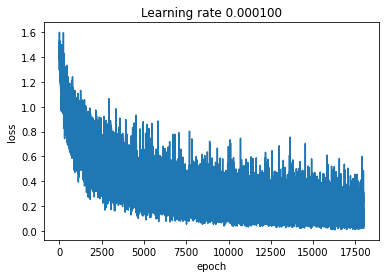

tensor(0.7125, device='cuda:0')


In [53]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()


accuracy = []

for images, labels in test_loader:
    pred_y = model(images.to(device))
    _, predicted = torch.max(pred_y, 1)
    _, test = torch.max(labels.to(device), 1)
    accuracy.append(torch.sum(predicted == test)/len(test))


print(sum(accuracy)/len(accuracy))